In [126]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import datetime
import scipy as sc
import seaborn as sns

### Load in Model volc-pinatubo-full data from local disk
Data downloaded using 440Project_download notebook
- CanESM
- MIROC ES2L
- UKESM1-0-LL

In [2]:
# Open volc-pinatubo-full Model Data
CCCma_ds = xr.open_dataarray("Data/CCCma.nc")
MIROC_ds = xr.open_dataarray("Data/MIROC.nc")
UKESM_ds = xr.open_dataarray("Data/UKESM.nc")

# Open Pre-Industrial Control Model Data
CCCmaPi = xr.open_dataset("Data/CCCmaPi.nc")
MIROCPi = xr.open_dataset("Data/MIROCPi.nc")
UKESMPi = xr.open_dataset("Data/UKESMPi.nc")

# Open NCEP Reanalysis Data
ncep_ds = xr.open_dataset("Data/ncep_temp.nc")

### Slice the Reanalysis Data to Time Period of Interest
June 1991 to June 1994

In [3]:
ncep_slice = ncep_ds.sel(time=slice(datetime.datetime(1991,6,1),datetime.datetime(1994,6,1)))
ncep_slice

<xarray.Dataset>
Dimensions:  (lon: 192, time: 37, lat: 94)
Coordinates:
  * lon      (lon) float32 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
  * time     (time) datetime64[ns] 1991-06-01 1991-07-01 ... 1994-06-01
  * lat      (lat) float32 88.54 86.65 84.75 82.85 ... -84.75 -86.65 -88.54
Data variables:
    air      (time, lat, lon) float32 ...
Attributes:
    Conventions:                     COARDS
    description:                     Data is from NMC initialized reanalysis\...
    platform:                        Model
    NCO:                             20121012
    history:                         created 97/10/04 by Hoop (netCDF2.3)\nCo...
    title:                           monthly mean air.2m from the NCEP Reanal...
    dataset_title:                   NCEP-NCAR Reanalysis 1
    _NCProperties:                   version=2,netcdf=4.6.2,hdf5=1.8.20
    References:                      http://www.psl.noaa.gov/data/gridded/dat...
    DODS_EXTRA.Unlimited_Dimension:  time

### Calculate a Monthly Climatology

In [4]:
CCCma_clim = CCCmaPi.groupby("time.month").mean("time")
print("Calculated CCCma Climatology")
MIROC_clim = MIROCPi.groupby("time.month").mean("time")
print("Calculated MIROC Climatology")
UKESM_clim = UKESMPi.groupby("time.month").mean("time")
print("Calculated UKESM Climatology")
ncep_clim = ncep_ds.groupby("time.month").mean(dim="time")
print("Calculated NCEP Climatology")

Calculated CCCma Climatology
Calculated MIROC Climatology
Calculated UKESM Climatology
Calculated NCEP Climatology


### Calculate the Temperature Anomaly

In [125]:
CCCma_anom = CCCma_ds.groupby("time.month") - CCCma_clim
print("Calculated CCCma anomaly")
MIROC_anom = MIROC_ds.groupby("time.month") - MIROC_clim
print("Calculated MIROC anomaly")
UKESM_anom = UKESM_ds.groupby("time.month") - UKESM_clim
print("Calculated UKESM anomaly")
ncep_anom = ncep_slice.groupby("time.month") - ncep_clim
print("Calculated NCEP Anomaly")

Calculated CCCma anomaly
Calculated MIROC anomaly
Calculated UKESM anomaly
Calculated NCEP Anomaly


### Calulate Weight Functions
This is to weigh the high latitudes less due to smaller grid boxes near the poles.

In [6]:
CCCma_coslat = np.cos(np.deg2rad(CCCma_anom.lat))
MIROC_coslat = np.cos(np.deg2rad(MIROC_anom.lat))
UKESM_coslat = np.cos(np.deg2rad(UKESM_anom.lat))
ncep_coslat = np.cos(np.deg2rad(ncep_anom.lat))

CCCma_weight_factor = CCCma_coslat / CCCma_coslat.mean(dim='lat') 
MIROC_weight_factor = MIROC_coslat / MIROC_coslat.mean(dim='lat') 
UKESM_weight_factor = UKESM_coslat / UKESM_coslat.mean(dim='lat') 
ncep_weight_factor = ncep_coslat / ncep_coslat.mean(dim='lat') 

### Calculate the Global Ensemble Mean Temperature Anomaly
For each model

In [7]:
CCCma_weighted = CCCma_anom * CCCma_weight_factor

CCCma_glb_mean = CCCma_weighted.tas.mean(dim=["member","lat","lon"])
CCCma_glb_mean_values = CCCma_glb_mean.values[0:37]

CCCma_ens_mean = CCCma_weighted.tas.mean(dim=["lat","lon"])
CCCma_std = CCCma_ens_mean.std(dim="member")
CCCma_max = CCCma_glb_mean+2*CCCma_std.values
CCCma_max_values = CCCma_max.values[0:37]
CCCma_min = CCCma_glb_mean-2*CCCma_std.values
CCCma_min_values = CCCma_min.values[0:37]

In [8]:
MIROC_weighted = MIROC_anom * MIROC_weight_factor

MIROC_glb_mean = MIROC_weighted.tas.mean(dim=["member","lat","lon"])
MIROC_glb_mean_values = MIROC_glb_mean.values[0:37]

MIROC_ens_mean = MIROC_weighted.tas.mean(dim=["lat","lon"])
MIROC_std = MIROC_ens_mean.std(dim="member")
MIROC_max = MIROC_glb_mean+2*MIROC_std.values
MIROC_max_values = MIROC_max.values[0:37]
MIROC_min = MIROC_glb_mean-2*MIROC_std.values
MIROC_min_values = MIROC_min.values[0:37]

In [9]:
UKESM_weighted = UKESM_anom * UKESM_weight_factor

UKESM_glb_mean = UKESM_weighted.tas.mean(dim=["member","lat","lon"])
UKESM_glb_mean_values = UKESM_glb_mean.values[0:37]

UKESM_ens_mean = UKESM_weighted.tas.mean(dim=["lat","lon"])
UKESM_std = UKESM_ens_mean.std(dim="member")
UKESM_max = UKESM_glb_mean+2*UKESM_std.values
UKESM_max_values = UKESM_max.values[0:37]
UKESM_min = UKESM_glb_mean-2*UKESM_std.values
UKESM_min_values = UKESM_min.values[0:37]

In [10]:
ncep_weighted = ncep_anom * ncep_weight_factor
ncep_glb_mean = ncep_weighted.air.mean(dim=["lon","lat"])
ncep_glb_mean_values = ncep_glb_mean.values[0:37]


In [11]:
time = UKESM_glb_mean.time.values
time = [datetime.datetime(vv.year,vv.month,vv.day) for vv in time] #convert from cftime to datetime for plotting
time_str = []
for t in time:
    time_str.append(datetime.datetime.strftime(t,'%Y-%m'))


### Plot Global Ensemble Average and Reanalysis Temperature Anomaly

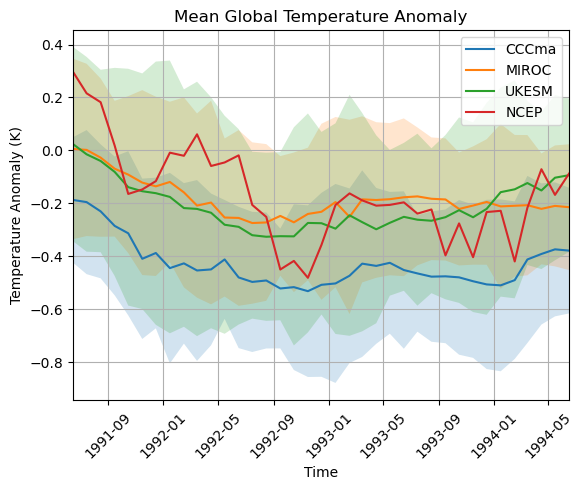

In [12]:
fig,ax = plt.subplots(1,1)
ax.plot(time, CCCma_glb_mean_values)
ax.fill_between(time,CCCma_min_values,CCCma_max_values, alpha=0.2)
ax.plot(time, MIROC_glb_mean_values)
ax.fill_between(time,MIROC_min_values,MIROC_max_values, alpha=0.2)
ax.plot(time, UKESM_glb_mean_values)
ax.fill_between(time,UKESM_min_values,UKESM_max_values, alpha=0.2)
ax.plot(time, ncep_glb_mean_values)
ax.legend(["CCCma",'MIROC','UKESM',"NCEP"])
ax.set(xlabel="Time", ylabel="Temperature Anomaly (K)",
       title="Mean Global Temperature Anomaly",
       xlim=(time[0],time[-1]))
plt.xticks(rotation=45)
ax.grid()

### Find Index with Largest Negative Temperature Anomaly

In [13]:
CCCma_min_anom_ind = np.where(CCCma_glb_mean_values == min(CCCma_glb_mean_values))
print(CCCma_min_anom_ind[0][0])
MIROC_min_anom_ind = np.where(MIROC_glb_mean_values == min(MIROC_glb_mean_values))
print(MIROC_min_anom_ind[0][0])
UKESM_min_anom_ind = np.where(UKESM_glb_mean_values == min(UKESM_glb_mean_values))
print(UKESM_min_anom_ind[0][0])
ncep_min_anom_ind = np.where(ncep_glb_mean_values == min(ncep_glb_mean_values))
print(ncep_min_anom_ind[0][0])

17
13
14
17


### Define function to make map 
Adapted from make_map function from assignment 5

In [14]:
def make_map(field, title="", levels=8):
    '''input field should be a 2D xarray.DataArray on a lat/lon grid.
        Make a filled contour plot of the field, and a line plot of the zonal mean
    '''
    fig = plt.figure(figsize=(14,6))
    nrows = 10; ncols = 3
    mapax = plt.subplot2grid((nrows,ncols), (0,0), colspan=ncols-1, rowspan=nrows-1, projection=ccrs.Robinson())
    barax = plt.subplot2grid((nrows,ncols), (nrows-1,0), colspan=ncols-1)
    plotax = plt.subplot2grid((nrows,ncols), (0,ncols-1), rowspan=nrows-1)
    # add cyclic point so cartopy doesn't show a white strip at zero longitude
    wrap_data, wrap_lon = add_cyclic_point(field.values, coord=field.lon, axis=field.dims.index('lon'))
    cx = mapax.contourf(wrap_lon, field.lat, wrap_data, levels=levels, transform=ccrs.PlateCarree(), extend='both')
    mapax.set_global(); mapax.coastlines();
    mapax.plot(120.35, 15.141667, "ro", transform=ccrs.PlateCarree())
    plt.colorbar(cx, cax=barax, orientation='horizontal', label='Temperature Anomaly (K)')
    plotax.plot(field.mean(dim='lon'), field.lat)
    plotax.set_xlabel('Zonal mean (K)')
    plotax.set_ylabel('Latitude')
    plotax.grid()
    fig.suptitle(title, fontsize=16)
    return fig, (mapax, plotax, barax), cx

### Produce Map and Zonal Mean of Temperature Anomaly
Ensemble mean temperature anomaly is plotted at time found above

/Users/andrewbarnett/miniconda3/envs/e440/lib/python3.10/site-packages/shapely/predicates.py:688: RuntimeWarning: invalid value encountered in covers
  return lib.covers(a, b, **kwargs)
/Users/andrewbarnett/miniconda3/envs/e440/lib/python3.10/site-packages/shapely/predicates.py:730: RuntimeWarning: invalid value encountered in disjoint
  return lib.disjoint(a, b, **kwargs)
/Users/andrewbarnett/miniconda3/envs/e440/lib/python3.10/site-packages/shapely/predicates.py:688: RuntimeWarning: invalid value encountered in covers
  return lib.covers(a, b, **kwargs)
/Users/andrewbarnett/miniconda3/envs/e440/lib/python3.10/site-packages/shapely/predicates.py:730: RuntimeWarning: invalid value encountered in disjoint
  return lib.disjoint(a, b, **kwargs)
/Users/andrewbarnett/miniconda3/envs/e440/lib/python3.10/site-packages/shapely/predicates.py:688: RuntimeWarning: invalid value encountered in covers
  return lib.covers(a, b, **kwargs)
/Users/andrewbarnett/miniconda3/envs/e440/lib/python3.10/site-

(-1.5, 1.0)

/Users/andrewbarnett/miniconda3/envs/e440/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/andrewbarnett/miniconda3/envs/e440/lib/python3.10/site-packages/shapely/predicates.py:688: RuntimeWarning: invalid value encountered in covers
  return lib.covers(a, b, **kwargs)
/Users/andrewbarnett/miniconda3/envs/e440/lib/python3.10/site-packages/shapely/predicates.py:730: RuntimeWarning: invalid value encountered in disjoint
  return lib.disjoint(a, b, **kwargs)
/Users/andrewbarnett/miniconda3/envs/e440/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(


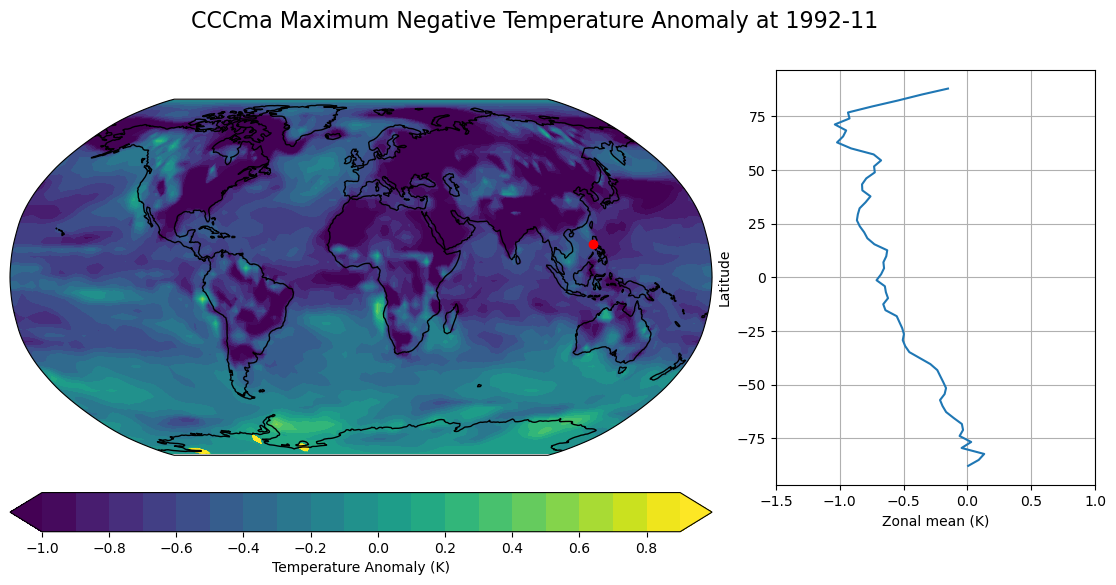

In [15]:
CCCma_min_anom = CCCma_weighted.tas.isel(time=CCCma_min_anom_ind[0][0]).mean(dim="member")

contours = np.arange(-1, 1, 0.1)
fig, axes, cx = make_map(CCCma_min_anom, levels=contours,
                        title=f"CCCma Maximum Negative Temperature Anomaly at {time_str[CCCma_min_anom_ind[0][0]]}")
axes[1].set_xlim(-1.5,1)  # ensure the line plots have same axes

/Users/andrewbarnett/miniconda3/envs/e440/lib/python3.10/site-packages/shapely/predicates.py:688: RuntimeWarning: invalid value encountered in covers
  return lib.covers(a, b, **kwargs)
/Users/andrewbarnett/miniconda3/envs/e440/lib/python3.10/site-packages/shapely/predicates.py:730: RuntimeWarning: invalid value encountered in disjoint
  return lib.disjoint(a, b, **kwargs)
/Users/andrewbarnett/miniconda3/envs/e440/lib/python3.10/site-packages/shapely/predicates.py:688: RuntimeWarning: invalid value encountered in covers
  return lib.covers(a, b, **kwargs)
/Users/andrewbarnett/miniconda3/envs/e440/lib/python3.10/site-packages/shapely/predicates.py:730: RuntimeWarning: invalid value encountered in disjoint
  return lib.disjoint(a, b, **kwargs)
/Users/andrewbarnett/miniconda3/envs/e440/lib/python3.10/site-packages/shapely/predicates.py:688: RuntimeWarning: invalid value encountered in covers
  return lib.covers(a, b, **kwargs)
/Users/andrewbarnett/miniconda3/envs/e440/lib/python3.10/site-

(-1.0, 1.0)

/Users/andrewbarnett/miniconda3/envs/e440/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/andrewbarnett/miniconda3/envs/e440/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(


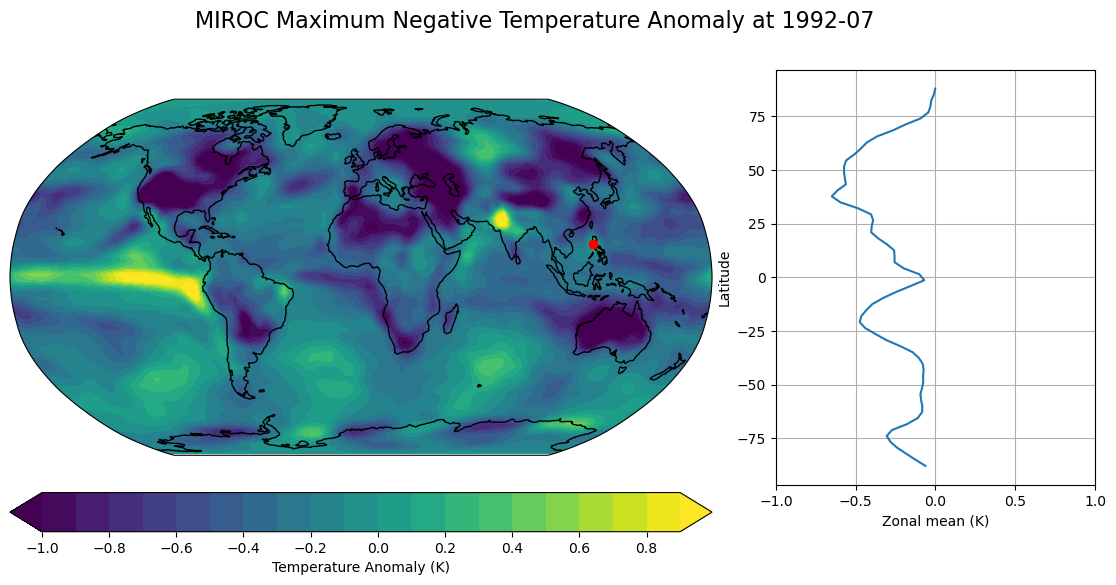

In [16]:
MIROC_min_anom = MIROC_weighted.tas.isel(time=MIROC_min_anom_ind[0][0]).mean(dim="member")

contours = np.arange(-1, 1, 0.1)
fig, axes, cx = make_map(MIROC_min_anom, levels=contours,
                        title=f"MIROC Maximum Negative Temperature Anomaly at {time_str[MIROC_min_anom_ind[0][0]]}")
axes[1].set_xlim(-1,1)  # ensure the line plots have same axes

(-1.0, 1.0)

/Users/andrewbarnett/miniconda3/envs/e440/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/andrewbarnett/miniconda3/envs/e440/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(


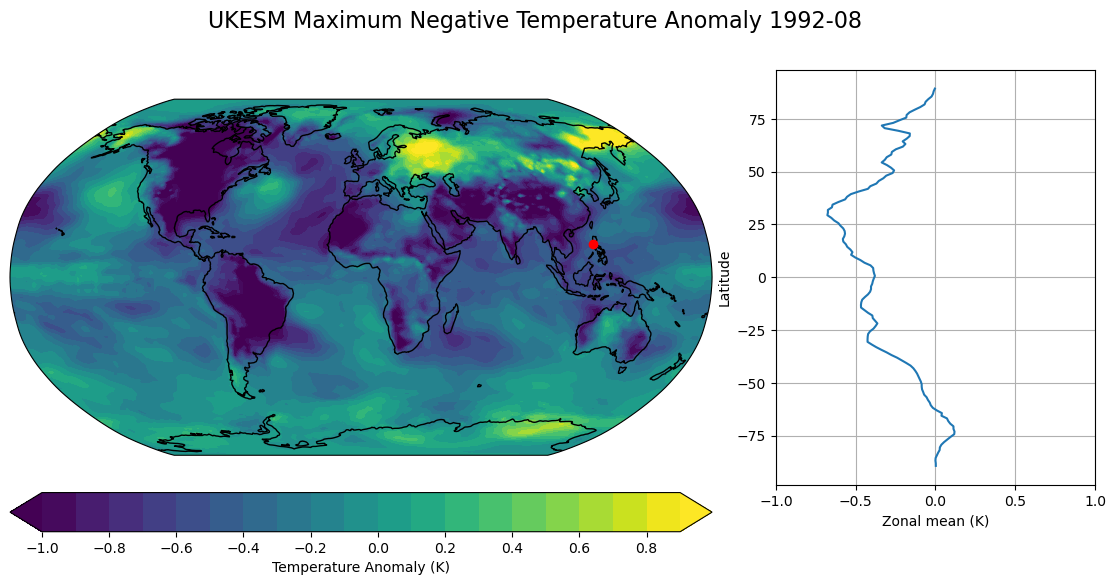

In [17]:
UKESM_min_anom = UKESM_weighted.tas.isel(time=CCCma_min_anom_ind[0][0]).mean(dim="member")

contours = np.arange(-1, 1, 0.1)
fig, axes, cx = make_map(UKESM_min_anom, levels=contours,
                        title=f"UKESM Maximum Negative Temperature Anomaly {time_str[UKESM_min_anom_ind[0][0]]}")
axes[1].set_xlim(-1,1)  # ensure the line plots have same axes

/Users/andrewbarnett/miniconda3/envs/e440/lib/python3.10/site-packages/shapely/predicates.py:688: RuntimeWarning: invalid value encountered in covers
  return lib.covers(a, b, **kwargs)
/Users/andrewbarnett/miniconda3/envs/e440/lib/python3.10/site-packages/shapely/predicates.py:730: RuntimeWarning: invalid value encountered in disjoint
  return lib.disjoint(a, b, **kwargs)
/Users/andrewbarnett/miniconda3/envs/e440/lib/python3.10/site-packages/shapely/predicates.py:688: RuntimeWarning: invalid value encountered in covers
  return lib.covers(a, b, **kwargs)
/Users/andrewbarnett/miniconda3/envs/e440/lib/python3.10/site-packages/shapely/predicates.py:730: RuntimeWarning: invalid value encountered in disjoint
  return lib.disjoint(a, b, **kwargs)
/Users/andrewbarnett/miniconda3/envs/e440/lib/python3.10/site-packages/shapely/predicates.py:688: RuntimeWarning: invalid value encountered in covers
  return lib.covers(a, b, **kwargs)
/Users/andrewbarnett/miniconda3/envs/e440/lib/python3.10/site-

(-2.0, 1.0)

/Users/andrewbarnett/miniconda3/envs/e440/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/andrewbarnett/miniconda3/envs/e440/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(


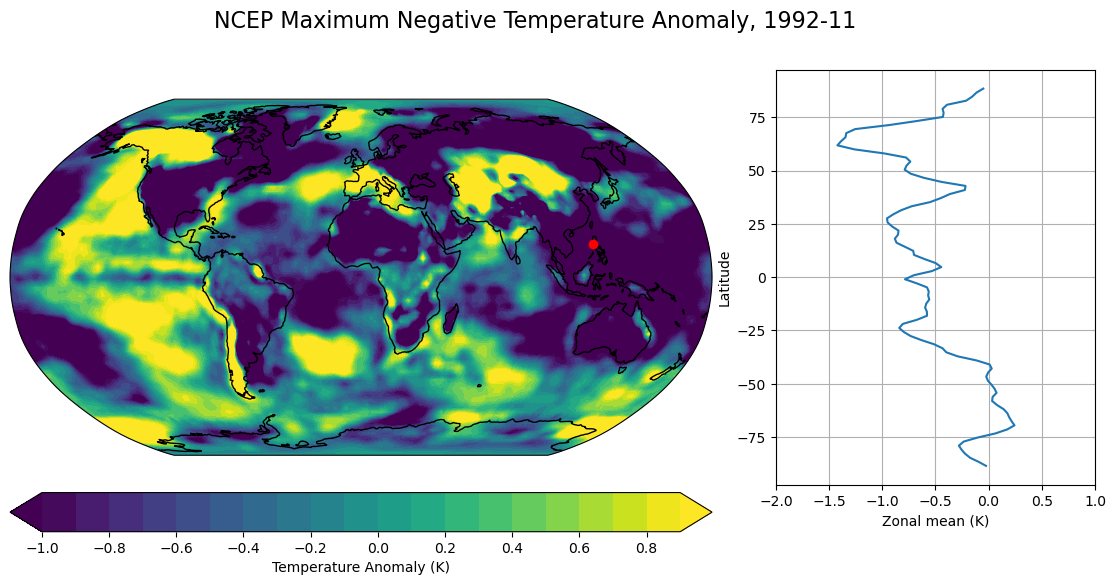

In [18]:
ncep_min_anom = ncep_weighted.air.isel(time=ncep_min_anom_ind[0][0])

contours = np.arange(-1, 1, 0.1)
fig, axes, cx = make_map(ncep_min_anom, levels=contours,
                        title=f"NCEP Maximum Negative Temperature Anomaly, {time_str[ncep_min_anom_ind[0][0]]}")
axes[1].set_xlim(-2,1)  # ensure the line plots have same axes

### Slice the data to Tropical latitude
Equator to 23.5 degrees N

In [123]:
# Slice tropics (Equator to 23.5 deg N )
CCCma_trop = CCCma_anom.sel(lat=slice(0,23.5))*CCCma_weight_factor
MIROC_trop= MIROC_anom.sel(lat=slice(0,23.5))*MIROC_weight_factor
UKESM_trop = UKESM_anom.sel(lat=slice(0,23.5))*UKESM_weight_factor
ncep_trop = ncep_anom.sel(lat=slice(23.5,0))*ncep_weight_factor

# Calculate tropical ensemble mean and standard deviation for CCCma model
CCCma_trop_mean = CCCma_trop.tas.mean(dim=["member","lat","lon"])
CCCma_trop_ens_mean = CCCma_trop.tas.mean(dim=["lat","lon"])
CCCma_trop_mean_values = CCCma_trop_mean.values[0:37]
CCCma_trop_std = CCCma_trop_ens_mean.std(dim="member")
CCCma_trop_max = CCCma_trop_mean+2*CCCma_trop_std.values
CCCma_trop_max_values = CCCma_trop_max.values[0:37]
CCCma_trop_min = CCCma_trop_mean-2*CCCma_trop_std.values
CCCma_trop_min_values = CCCma_trop_min.values[0:37]

# Calculate tropical ensemble mean and standard deviation for MIROC model
MIROC_trop_mean = MIROC_trop.tas.mean(dim=["member","lat","lon"])
MIROC_trop_ens_mean = MIROC_trop.tas.mean(dim=["lat","lon"])
MIROC_trop_mean_values = MIROC_trop_mean.values[0:37]
MIROC_trop_std = MIROC_trop_ens_mean.std(dim="member")
MIROC_trop_max = MIROC_trop_mean+2*MIROC_trop_std.values
MIROC_trop_max_values = MIROC_trop_max.values[0:37]
MIROC_trop_min = MIROC_trop_mean-2*MIROC_trop_std.values
MIROC_trop_min_values = MIROC_trop_min.values[0:37]

# Calculate tropical ensemble mean and standard deviation for UKESM model
UKESM_trop_mean = UKESM_trop.tas.mean(dim=["member","lat","lon"])
UKESM_trop_ens_mean = UKESM_trop.tas.mean(dim=["lat","lon"])
UKESM_trop_mean_values = UKESM_trop_mean.values[0:37]
UKESM_trop_std = UKESM_trop_ens_mean.std(dim="member")
UKESM_trop_max = UKESM_trop_mean+2*UKESM_trop_std.values
UKESM_trop_max_values = UKESM_trop_max.values[0:37]
UKESM_trop_min = UKESM_trop_mean-2*UKESM_trop_std.values
UKESM_trop_min_values = UKESM_trop_min.values[0:37]

# Calculate tropical mean for reanalysis data
ncep_trop_mean = ncep_trop.air.mean(dim=["lat","lon"])
ncep_trop_mean_values = ncep_trop_mean.values[0:37]

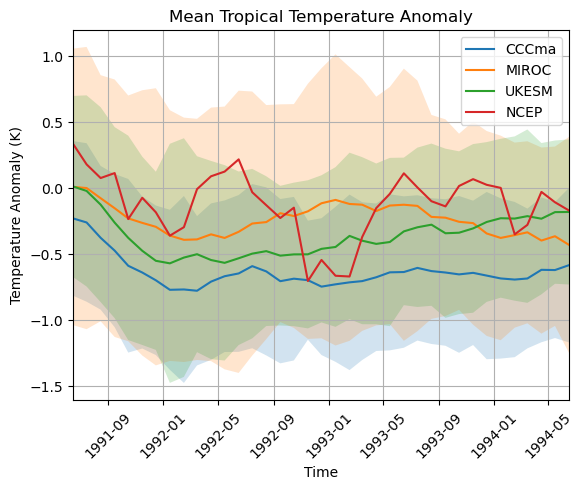

In [124]:
fig,ax = plt.subplots(1,1)
ax.plot(time, CCCma_trop_mean_values)
ax.fill_between(time,CCCma_trop_min_values,CCCma_trop_max_values, alpha=0.2)
ax.plot(time, MIROC_trop_mean_values)
ax.fill_between(time,MIROC_trop_min_values,MIROC_trop_max_values, alpha=0.2)
ax.plot(time, UKESM_trop_mean_values)
ax.fill_between(time,UKESM_trop_min_values,UKESM_trop_max_values, alpha=0.2)
ax.plot(time, ncep_trop_mean_values)
ax.legend(["CCCma",'MIROC','UKESM',"NCEP"])
ax.set(xlabel="Time", ylabel="Temperature Anomaly (K)",
       title="Mean Tropical Temperature Anomaly",
       xlim=(time[0],time[-1]))
plt.xticks(rotation=45)
ax.grid()

### Make Maps of Maximum Negative Temperature anomaly

In [21]:
def make_mini_map(field, title="", levels=8):
    wrap_data, wrap_lon = add_cyclic_point(field.values, coord=field.lon, axis=field.dims.index('lon'))
    cx.contourf(wrap_lon, field.lat, wrap_data, levels=levels, transform=ccrs.PlateCarree(), extend='both')
    cx.set_global(); mapax.coastlines();
    cx.plot(120.35, 15.141667, "ro", transform=ccrs.PlateCarree())
    return cx

/Users/andrewbarnett/miniconda3/envs/e440/lib/python3.10/site-packages/shapely/predicates.py:688: RuntimeWarning: invalid value encountered in covers
  return lib.covers(a, b, **kwargs)
/Users/andrewbarnett/miniconda3/envs/e440/lib/python3.10/site-packages/shapely/predicates.py:730: RuntimeWarning: invalid value encountered in disjoint
  return lib.disjoint(a, b, **kwargs)
/Users/andrewbarnett/miniconda3/envs/e440/lib/python3.10/site-packages/shapely/predicates.py:688: RuntimeWarning: invalid value encountered in covers
  return lib.covers(a, b, **kwargs)
/Users/andrewbarnett/miniconda3/envs/e440/lib/python3.10/site-packages/shapely/predicates.py:730: RuntimeWarning: invalid value encountered in disjoint
  return lib.disjoint(a, b, **kwargs)
/Users/andrewbarnett/miniconda3/envs/e440/lib/python3.10/site-packages/shapely/predicates.py:688: RuntimeWarning: invalid value encountered in covers
  return lib.covers(a, b, **kwargs)
/Users/andrewbarnett/miniconda3/envs/e440/lib/python3.10/site-

Text(0.5, 0.98, 'Maximum Negative Global Temperature Anomaly')

/Users/andrewbarnett/miniconda3/envs/e440/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/andrewbarnett/miniconda3/envs/e440/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(


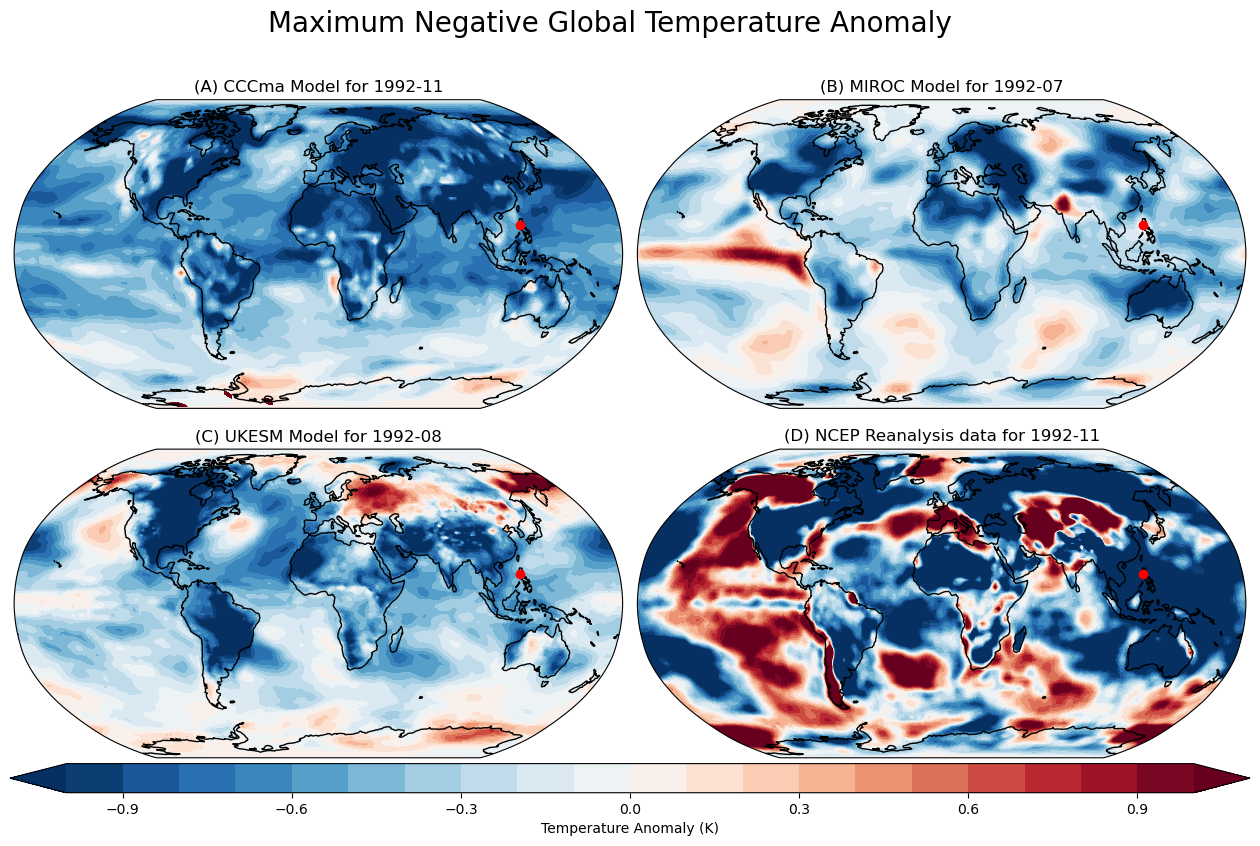

In [99]:
contours = np.arange(-1, 1.1, 0.1)
fig = plt.figure(figsize = (16,9))
nrows = 20
ncols = 32
ax1 = plt.subplot2grid((nrows,ncols), (0,0), colspan=16, rowspan=9, projection=ccrs.Robinson())
ax2 = plt.subplot2grid((nrows,ncols), (0,16), colspan=16, rowspan=9, projection=ccrs.Robinson())
ax3 = plt.subplot2grid((nrows,ncols), (10,0), colspan=16, rowspan=9, projection=ccrs.Robinson())
ax4 = plt.subplot2grid((nrows,ncols), (10,16), colspan=16, rowspan=9, projection=ccrs.Robinson())
barax = plt.subplot2grid((nrows,ncols), (19,0), colspan=32, rowspan=1)

CCCma_data, CCCma_lon = add_cyclic_point(CCCma_min_anom.values, coord=CCCma_min_anom.lon, axis=CCCma_min_anom.dims.index('lon'))
MIROC_data, MIROC_lon = add_cyclic_point(MIROC_min_anom.values, coord=MIROC_min_anom.lon, axis=MIROC_min_anom.dims.index('lon'))
UKESM_data, UKESM_lon = add_cyclic_point(UKESM_min_anom.values, coord=UKESM_min_anom.lon, axis=UKESM_min_anom.dims.index('lon'))
ncep_data, ncep_lon = add_cyclic_point(ncep_min_anom.values, coord=ncep_min_anom.lon, axis=ncep_min_anom.dims.index('lon'))

cx1 = ax1.contourf(CCCma_lon, CCCma_min_anom.lat, CCCma_data, levels=contours, transform=ccrs.PlateCarree(), extend='both', cmap="RdBu_r")
cx2 = ax2.contourf(MIROC_lon, MIROC_min_anom.lat, MIROC_data, levels=contours, transform=ccrs.PlateCarree(), extend='both', cmap="RdBu_r")
cx3 = ax3.contourf(UKESM_lon, UKESM_min_anom.lat, UKESM_data, levels=contours, transform=ccrs.PlateCarree(), extend='both', cmap="RdBu_r")
cx4 = ax4.contourf(ncep_lon, ncep_min_anom.lat, ncep_data, levels=contours, transform=ccrs.PlateCarree(), extend='both', cmap="RdBu_r")

ax1.set_global(); ax1.coastlines();
ax1.plot(120.35, 15.141667, "ro", transform=ccrs.PlateCarree())
ax2.set_global(); ax2.coastlines();
ax2.plot(120.35, 15.141667, "ro", transform=ccrs.PlateCarree())
ax3.set_global(); ax3.coastlines();
ax3.plot(120.35, 15.141667, "ro", transform=ccrs.PlateCarree())
ax4.set_global(); ax4.coastlines();
ax4.plot(120.35, 15.141667, "ro", transform=ccrs.PlateCarree())

plt.colorbar(cx1, cax=barax, orientation='horizontal', label='Temperature Anomaly (K)')
ax1.set(title = f"(A) CCCma Model for {time_str[CCCma_min_anom_ind[0][0]]}")
ax2.set(title = f"(B) MIROC Model for {time_str[MIROC_min_anom_ind[0][0]]}")
ax3.set(title = f"(C) UKESM Model for {time_str[UKESM_min_anom_ind[0][0]]}")
ax4.set(title = f"(D) NCEP Reanalysis data for {time_str[ncep_min_anom_ind[0][0]]}")
fig.suptitle("Maximum Negative Global Temperature Anomaly", fontsize=20)

### Clip Model to Various Latitudinal Regions

In [23]:
def clip_model(anom,weight_factor,lower,upper):
    # Slice to desired latitude band
    anom_slice = anom.sel(lat=slice(lower,upper))*weight_factor

    # Calculate ensemble mean and standard deviation
    anom_mean = anom_slice.tas.mean(dim=["member","lat","lon"])
    anom_ens_mean = anom_slice.tas.mean(dim=["lat","lon"])
    anom_mean_values = anom_mean.values[0:37]
    anom_std = anom_ens_mean.std(dim="member")
    anom_max = anom_mean+2*anom_std.values
    anom_max_values = anom_max.values[0:37]
    anom_min = anom_mean-2*anom_std.values
    anom_min_values = anom_min.values[0:37]
    return anom_mean_values, anom_max_values, anom_min_values

def clip_ncep(ncep,weight_factor,lower,upper):
    ncep_slice = ncep.sel(lat=slice(upper,lower))*weight_factor
    ncep_slice_mean = ncep_slice.air.mean(dim=["lat","lon"])
    ncep_slice_mean_values = ncep_slice_mean.values[0:37]

    return ncep_slice_mean_values

In [24]:
CCCma_NH_mean, CCCma_NH_max, CCCma_NH_min = clip_model(CCCma_anom,CCCma_weight_factor,0,90)
MIROC_NH_mean, MIROC_NH_max, MIROC_NH_min = clip_model(MIROC_anom,MIROC_weight_factor,0,90)
UKESM_NH_mean, UKESM_NH_max, UKESM_NH_min = clip_model(UKESM_anom,UKESM_weight_factor,0,90)
ncep_NH_mean = clip_ncep(ncep_anom,ncep_weight_factor,0,90)

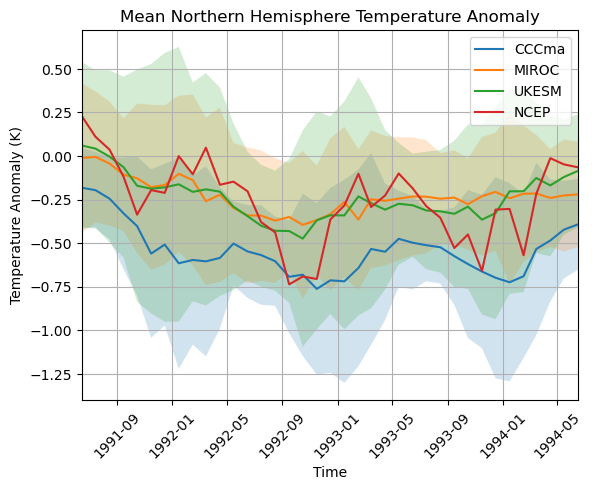

In [25]:
fig,ax = plt.subplots(1,1)
ax.plot(time, CCCma_NH_mean)
ax.fill_between(time,CCCma_NH_min,CCCma_NH_max, alpha=0.2)
ax.plot(time, MIROC_NH_mean)
ax.fill_between(time,MIROC_NH_min,MIROC_NH_max, alpha=0.2)
ax.plot(time, UKESM_NH_mean)
ax.fill_between(time,UKESM_NH_min,UKESM_NH_max, alpha=0.2)
ax.plot(time, ncep_NH_mean)
ax.legend(["CCCma",'MIROC','UKESM',"NCEP"])
ax.set(xlabel="Time", ylabel="Temperature Anomaly (K)",
       title="Mean Northern Hemisphere Temperature Anomaly",
       xlim=(time[0],time[-1]))
plt.xticks(rotation=45)
ax.grid()

In [26]:
CCCma_SH_mean, CCCma_SH_max, CCCma_SH_min = clip_model(CCCma_anom,CCCma_weight_factor,-90,0)
MIROC_SH_mean, MIROC_SH_max, MIROC_SH_min = clip_model(MIROC_anom,MIROC_weight_factor,-90,0)
UKESM_SH_mean, UKESM_SH_max, UKESM_SH_min = clip_model(UKESM_anom,UKESM_weight_factor,-90,0)
ncep_SH_mean = clip_ncep(ncep_anom,ncep_weight_factor,-90,0)

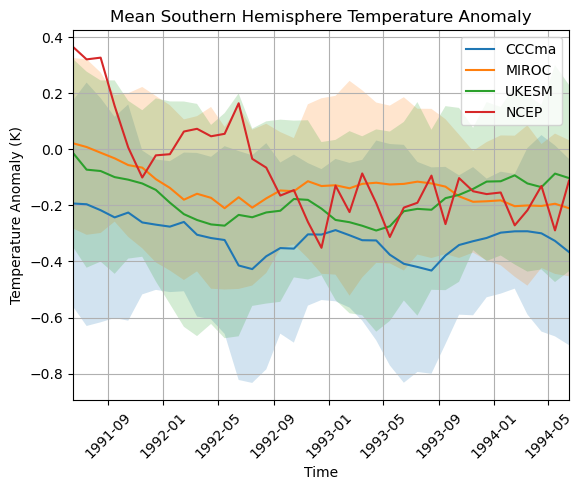

In [27]:
fig,ax = plt.subplots(1,1)
ax.plot(time, CCCma_SH_mean)
ax.fill_between(time,CCCma_SH_min,CCCma_SH_max, alpha=0.2)
ax.plot(time, MIROC_SH_mean)
ax.fill_between(time,MIROC_SH_min,MIROC_SH_max, alpha=0.2)
ax.plot(time, UKESM_SH_mean)
ax.fill_between(time,UKESM_SH_min,UKESM_SH_max, alpha=0.2)
ax.plot(time, ncep_SH_mean)
ax.legend(["CCCma",'MIROC','UKESM',"NCEP"])
ax.set(xlabel="Time", ylabel="Temperature Anomaly (K)",
       title="Mean Southern Hemisphere Temperature Anomaly",
       xlim=(time[0],time[-1]))
plt.xticks(rotation=45)
ax.grid()

In [28]:
CCCma_arc_mean, CCCma_arc_max, CCCma_arc_min = clip_model(CCCma_anom,CCCma_weight_factor,60,90)
MIROC_arc_mean, MIROC_arc_max, MIROC_arc_min = clip_model(MIROC_anom,MIROC_weight_factor,60,90)
UKESM_arc_mean, UKESM_arc_max, UKESM_arc_min = clip_model(UKESM_anom,UKESM_weight_factor,60,90)
ncep_arc_mean = clip_ncep(ncep_anom,ncep_weight_factor,60,90)

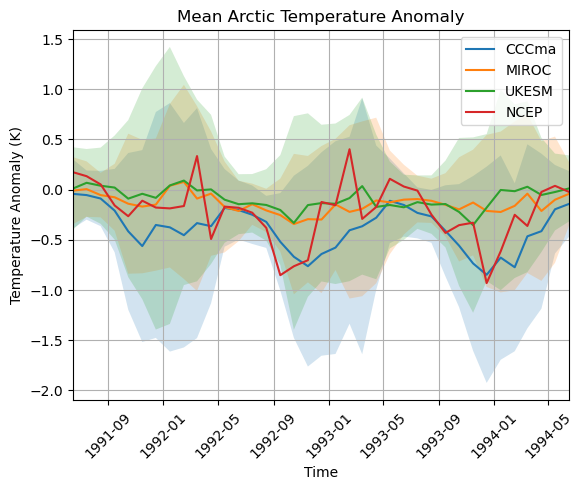

In [30]:
fig,ax = plt.subplots(1,1)
ax.plot(time, CCCma_arc_mean)
ax.fill_between(time,CCCma_arc_min,CCCma_arc_max, alpha=0.2)
ax.plot(time, MIROC_arc_mean)
ax.fill_between(time,MIROC_arc_min,MIROC_arc_max, alpha=0.2)
ax.plot(time, UKESM_arc_mean)
ax.fill_between(time,UKESM_arc_min,UKESM_arc_max, alpha=0.2)
ax.plot(time, ncep_arc_mean)
ax.legend(["CCCma",'MIROC','UKESM',"NCEP"])
ax.set(xlabel="Time", ylabel="Temperature Anomaly (K)",
       title="Mean Arctic Temperature Anomaly",
       xlim=(time[0],time[-1]))
plt.xticks(rotation=45)
ax.grid()

In [31]:
CCCma_trop_mean, CCCma_trop_max, CCCma_trop_min = clip_model(CCCma_anom,CCCma_weight_factor,0,23.5)
MIROC_trop_mean, MIROC_trop_max, MIROC_trop_min = clip_model(MIROC_anom,MIROC_weight_factor,0,23.5)
UKESM_trop_mean, UKESM_trop_max, UKESM_trop_min = clip_model(UKESM_anom,UKESM_weight_factor,0,23.5)
ncep_trop_mean = clip_ncep(ncep_anom,ncep_weight_factor,0,23.5)

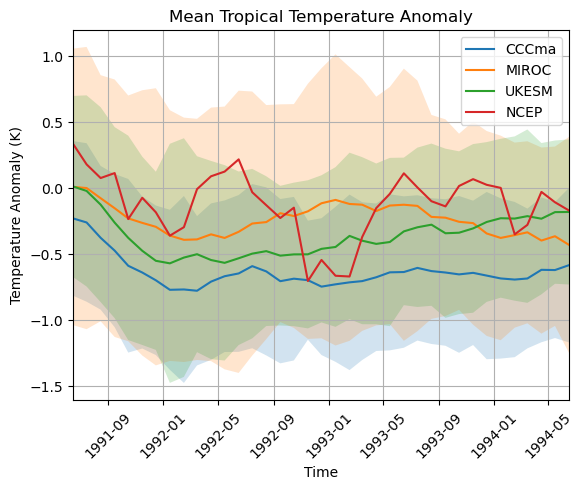

In [32]:
fig,ax = plt.subplots(1,1)
ax.plot(time, CCCma_trop_mean)
ax.fill_between(time,CCCma_trop_min,CCCma_trop_max, alpha=0.2)
ax.plot(time, MIROC_trop_mean)
ax.fill_between(time,MIROC_trop_min,MIROC_trop_max, alpha=0.2)
ax.plot(time, UKESM_trop_mean)
ax.fill_between(time,UKESM_trop_min,UKESM_trop_max, alpha=0.2)
ax.plot(time, ncep_trop_mean)
ax.legend(["CCCma",'MIROC','UKESM',"NCEP"])
ax.set(xlabel="Time", ylabel="Temperature Anomaly (K)",
       title="Mean Tropical Temperature Anomaly",
       xlim=(time[0],time[-1]))
plt.xticks(rotation=45)
ax.grid()

Text(0.5, 0.98, 'Mean Temperature Anomaly          ')

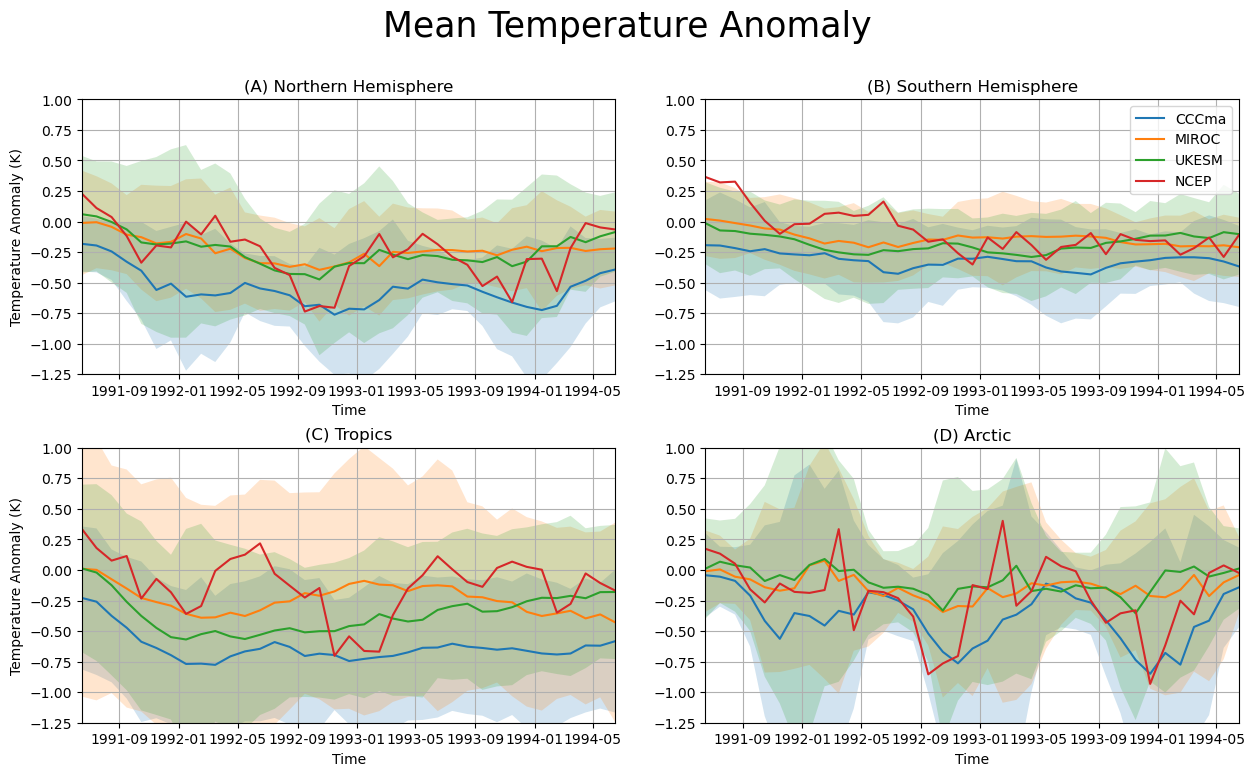

In [100]:
fig = plt.figure(figsize = (16,9))
nrows = 30
ncols = 30
ax1 = plt.subplot2grid((nrows,ncols), (0,0), colspan=13, rowspan=12)
ax2 = plt.subplot2grid((nrows,ncols), (0,15), colspan=13, rowspan=12)
ax3 = plt.subplot2grid((nrows,ncols), (15,0), colspan=13, rowspan=12)
ax4 = plt.subplot2grid((nrows,ncols), (15,15), colspan=13, rowspan=12)

ax1.plot(time, CCCma_NH_mean)
ax1.fill_between(time,CCCma_NH_min,CCCma_NH_max, alpha=0.2)
ax1.plot(time, MIROC_NH_mean)
ax1.fill_between(time,MIROC_NH_min,MIROC_NH_max, alpha=0.2)
ax1.plot(time, UKESM_NH_mean)
ax1.fill_between(time,UKESM_NH_min,UKESM_NH_max, alpha=0.2)
ax1.plot(time, ncep_NH_mean)
ax1.set(xlabel="Time", ylabel="Temperature Anomaly (K)",
       title="(A) Northern Hemisphere",
       xlim=(time[0],time[-1]),
       ylim=(-1.25,1))
ax1.grid()

ax2.plot(time, CCCma_SH_mean)
ax2.fill_between(time,CCCma_SH_min,CCCma_SH_max, alpha=0.2)
ax2.plot(time, MIROC_SH_mean)
ax2.fill_between(time,MIROC_SH_min,MIROC_SH_max, alpha=0.2)
ax2.plot(time, UKESM_SH_mean)
ax2.fill_between(time,UKESM_SH_min,UKESM_SH_max, alpha=0.2)
ax2.plot(time, ncep_SH_mean)
ax2.legend(["CCCma",'MIROC','UKESM',"NCEP"])
ax2.set(xlabel="Time",
        title="(B) Southern Hemisphere",
        xlim=(time[0],time[-1]),
        ylim=(-1.25,1))
ax2.grid()

ax3.plot(time, CCCma_trop_mean)
ax3.fill_between(time,CCCma_trop_min,CCCma_trop_max, alpha=0.2)
ax3.plot(time, MIROC_trop_mean)
ax3.fill_between(time,MIROC_trop_min,MIROC_trop_max, alpha=0.2)
ax3.plot(time, UKESM_trop_mean)
ax3.fill_between(time,UKESM_trop_min,UKESM_trop_max, alpha=0.2)
ax3.plot(time, ncep_trop_mean)
ax3.set(xlabel="Time", ylabel="Temperature Anomaly (K)",
        title="(C) Tropics",
        xlim=(time[0],time[-1]),
        ylim=(-1.25,1))
ax3.grid()

ax4.plot(time, CCCma_arc_mean)
ax4.fill_between(time,CCCma_arc_min,CCCma_arc_max, alpha=0.2)
ax4.plot(time, MIROC_arc_mean)
ax4.fill_between(time,MIROC_arc_min,MIROC_arc_max, alpha=0.2)
ax4.plot(time, UKESM_arc_mean)
ax4.fill_between(time,UKESM_arc_min,UKESM_arc_max, alpha=0.2)
ax4.plot(time, ncep_arc_mean)
ax4.set(xlabel="Time",
        title="(D) Arctic",
        xlim=(time[0],time[-1]),
        ylim=(-1.25,1))
ax4.grid()

fig.suptitle("Mean Temperature Anomaly          ", fontsize=25)


Text(0.5, 0.98, 'Zonal Mean Temperature Anomaly          ')

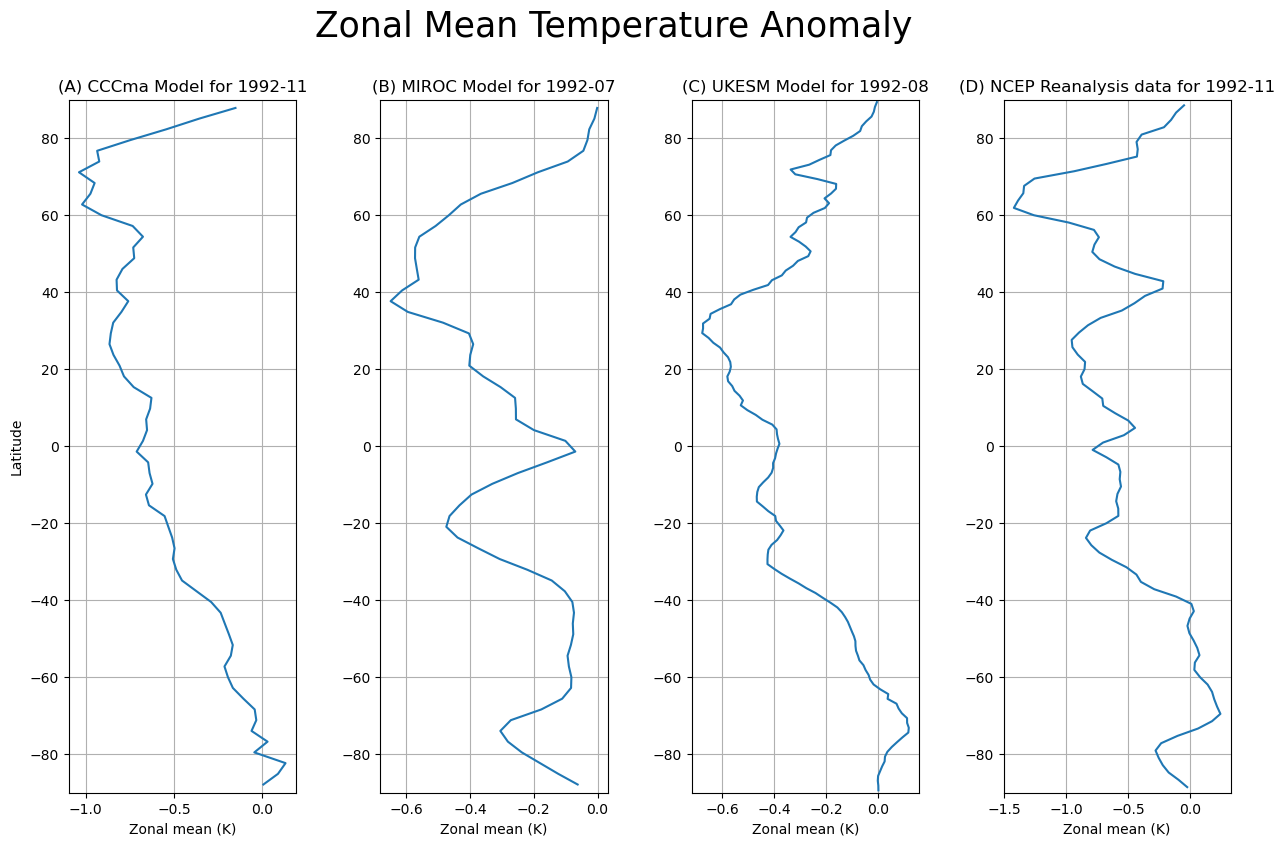

In [101]:
fig = plt.figure(figsize = (16,9))
nrows = 32
ncols = 32
ax1 = plt.subplot2grid((nrows,ncols), (0,0), colspan=6, rowspan=32)
ax2 = plt.subplot2grid((nrows,ncols), (0,8), colspan=6, rowspan=32)
ax3 = plt.subplot2grid((nrows,ncols), (0,16), colspan=6, rowspan=32)
ax4 = plt.subplot2grid((nrows,ncols), (0,24), colspan=6, rowspan=32)

ax1.plot(CCCma_min_anom.mean(dim='lon'), CCCma_min_anom.lat)
ax1.set_xlabel('Zonal mean (K)')
ax1.set_ylabel('Latitude')
ax1.set_ylim(-90,90)
ax1.grid()

ax2.plot(MIROC_min_anom.mean(dim='lon'), MIROC_min_anom.lat)
ax2.set_xlabel('Zonal mean (K)')
ax2.set_ylim(-90,90)
ax2.grid()

ax3.plot(UKESM_min_anom.mean(dim='lon'), UKESM_min_anom.lat)
ax3.set_xlabel('Zonal mean (K)')
ax3.set_ylim(-90,90)
ax3.grid()

ax4.plot(ncep_min_anom.mean(dim='lon'), ncep_min_anom.lat)
ax4.set_xlabel('Zonal mean (K)')
ax4.set_ylim(-90,90)
ax4.grid()

ax1.set(title = f"(A) CCCma Model for {time_str[CCCma_min_anom_ind[0][0]]}")
ax2.set(title = f"(B) MIROC Model for {time_str[MIROC_min_anom_ind[0][0]]}")
ax3.set(title = f"(C) UKESM Model for {time_str[UKESM_min_anom_ind[0][0]]}")
ax4.set(title = f"(D) NCEP Reanalysis data for {time_str[ncep_min_anom_ind[0][0]]}")

fig.suptitle("Zonal Mean Temperature Anomaly          ", fontsize=25)

/var/folders/kl/srfdnvh96kg823hjpbs6plpc0000gn/T/ipykernel_19536/301212197.py:16: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  m.plot(x,y, color="r",marker="o", MarkerSize=15)


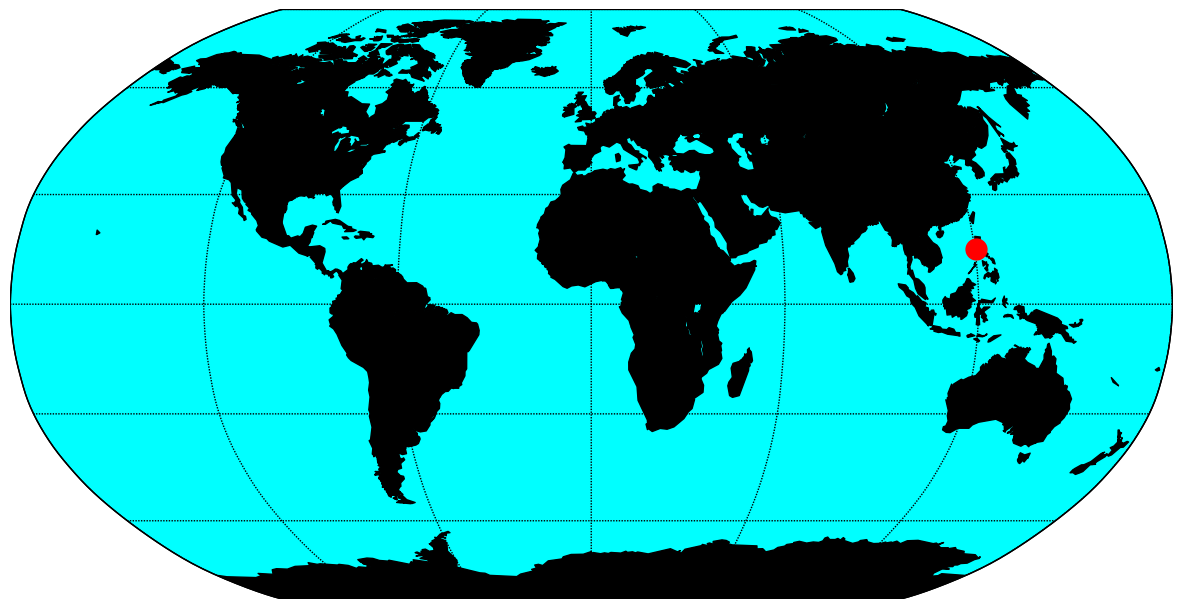

In [122]:
from mpl_toolkits.basemap import Basemap
import numpy as np
import matplotlib.pyplot as plt
# lon_0 is central longitude of projection.
# resolution = 'c' means use crude resolution coastlines.
plt.figure(figsize=(15,10))
m = Basemap(projection='robin',lon_0=0,resolution='c')
m.drawcoastlines()
m.fillcontinents(color='black',lake_color='aqua')
# draw parallels and meridians.
m.drawparallels(np.arange(-90.,120.,30.))
m.drawmeridians(np.arange(0.,360.,60.))
m.drawmapboundary(fill_color='aqua') 
x,y = m(120.35, 15.141667)
m.plot(x,y, color="r",marker="o", MarkerSize=15)
plt.show()


Text(0.5, 0.98, 'Mean Temperature Anomaly Deviation from Reanalysis Data        ')

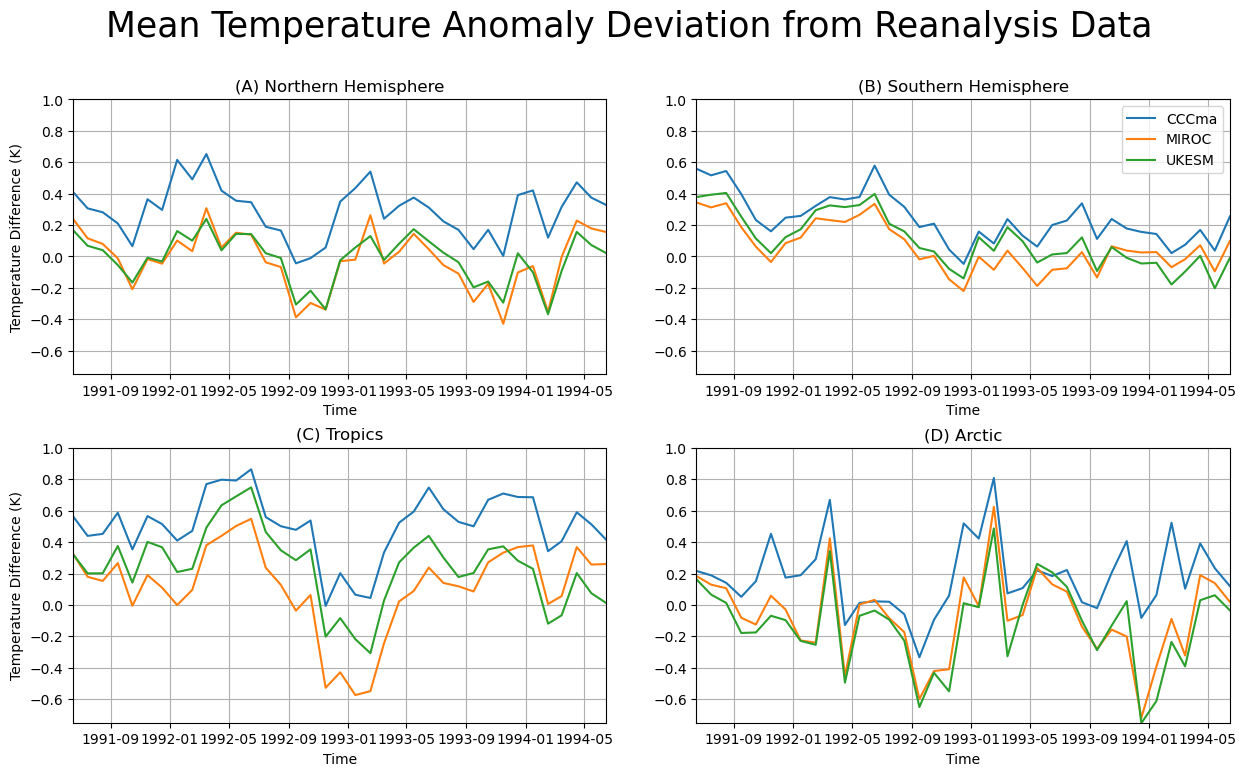

In [102]:
fig = plt.figure(figsize = (16,9))
nrows = 30
ncols = 30
ax1 = plt.subplot2grid((nrows,ncols), (0,0), colspan=13, rowspan=12)
ax2 = plt.subplot2grid((nrows,ncols), (0,15), colspan=13, rowspan=12)
ax3 = plt.subplot2grid((nrows,ncols), (15,0), colspan=13, rowspan=12)
ax4 = plt.subplot2grid((nrows,ncols), (15,15), colspan=13, rowspan=12)

ax1.plot(time, ncep_NH_mean-CCCma_NH_mean)
ax1.plot(time, ncep_NH_mean-MIROC_NH_mean)
ax1.plot(time, ncep_NH_mean-UKESM_NH_mean)
ax1.set(xlabel="Time", ylabel="Temperature Difference (K)",
        title="(A) Northern Hemisphere",
        xlim=(time[0],time[-1]),
        ylim=(-0.75,1))
ax1.grid()

ax2.plot(time, ncep_SH_mean-CCCma_SH_mean)
ax2.plot(time, ncep_SH_mean-MIROC_SH_mean)
ax2.plot(time, ncep_SH_mean-UKESM_SH_mean)
ax2.legend(["CCCma",'MIROC','UKESM'])
ax2.set(xlabel="Time",
        title="(B) Southern Hemisphere",
        xlim=(time[0],time[-1]),
        ylim=(-0.75,1))
ax2.grid()

ax3.plot(time, ncep_trop_mean-CCCma_trop_mean)
ax3.plot(time, ncep_trop_mean-MIROC_trop_mean)
ax3.plot(time, ncep_trop_mean-UKESM_trop_mean)
ax3.set(xlabel="Time", ylabel="Temperature Difference (K)",
        title="(C) Tropics",
        xlim=(time[0],time[-1]),
        ylim=(-0.75,1))
ax3.grid()

ax4.plot(time, ncep_arc_mean-CCCma_arc_mean)
ax4.plot(time, ncep_arc_mean-MIROC_arc_mean)
ax4.plot(time, ncep_arc_mean-UKESM_arc_mean)
ax4.set(xlabel="Time",
        title="(D) Arctic",
        xlim=(time[0],time[-1]),
        ylim=(-0.75,1))
ax4.grid()

fig.suptitle("Mean Temperature Anomaly Deviation from Reanalysis Data        ", fontsize=25)

CCCma
slope = 0.4239998963339703
intercept = -0.4371141383626312
r = 0.6918908472528871
p = 2.106768193605635e-06
stdev = 0.07478811945993034
MIROC
slope = 0.2613226849065425
intercept = -0.16511107858840118
r = 0.6302706907028159
p = 2.9069918331585715e-05
stdev = 0.05441113407152266
UKESM
slope = 0.4334174104998096
intercept = -0.13083915799824525
r = 0.786179261982524
p = 8.106906931323278e-09
stdev = 0.057588820104090346


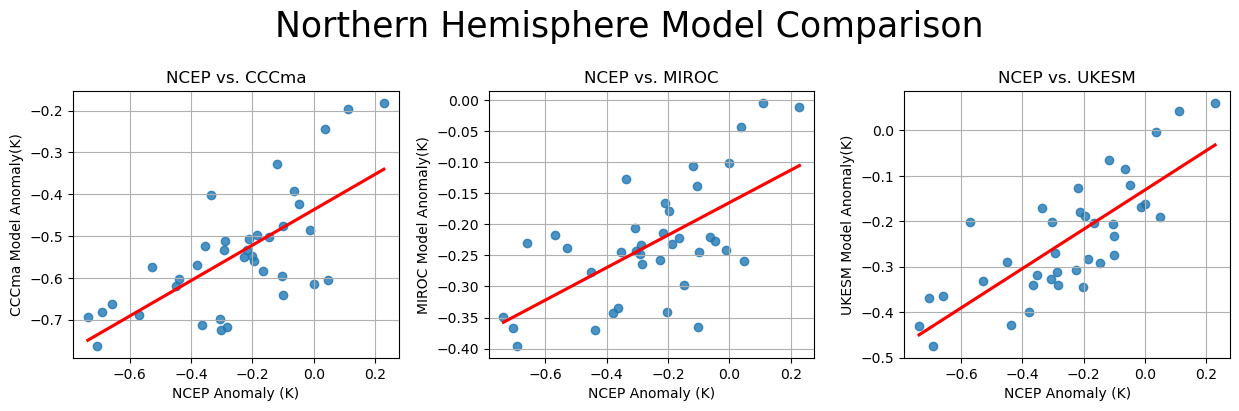

In [116]:
fig = plt.figure(figsize = (16,4))
nrows = 30
ncols = 30
ax1 = plt.subplot2grid((nrows,ncols), (4,0), colspan=8, rowspan=26)
ax2 = plt.subplot2grid((nrows,ncols), (4,10), colspan=8, rowspan=26)
ax3 = plt.subplot2grid((nrows,ncols), (4,20), colspan=8, rowspan=26)

ax1.grid()
sns.regplot(x=ncep_NH_mean, y=CCCma_NH_mean, ci=False, line_kws={'color':'red'}, ax=ax1);
ax1.set(xlabel="NCEP Anomaly (K)", ylabel="CCCma Model Anomaly(K)",
       title="NCEP vs. CCCma")

ax2.grid()
sns.regplot(x=ncep_NH_mean, y=MIROC_NH_mean, ci=False, line_kws={'color':'red'}, ax=ax2);
ax2.set(xlabel="NCEP Anomaly (K)", ylabel="MIROC Model Anomaly(K)",
       title="NCEP vs. MIROC")

ax3.grid()
sns.regplot(x=ncep_NH_mean, y=UKESM_NH_mean, ci=False, line_kws={'color':'red'}, ax=ax3);
ax3.set(xlabel="NCEP Anomaly (K)", ylabel="UKESM Model Anomaly(K)",
       title="NCEP vs. UKESM")

fig.suptitle("Northern Hemisphere Model Comparison        ", fontsize=25)

result1 = sc.stats.linregress(ncep_NH_mean, CCCma_NH_mean)
print("CCCma")
print(f"slope = {result1.slope}")
print(f"intercept = {result1.intercept}")
print(f"r = {result1.rvalue}")
print(f"p = {result1.pvalue}")
print(f"stdev = {result1.stderr}")

result2 = sc.stats.linregress(ncep_NH_mean, MIROC_NH_mean)
print("MIROC")
print(f"slope = {result2.slope}")
print(f"intercept = {result2.intercept}")
print(f"r = {result2.rvalue}")
print(f"p = {result2.pvalue}")
print(f"stdev = {result2.stderr}")

result3 = sc.stats.linregress(ncep_NH_mean, UKESM_NH_mean)
print("UKESM")
print(f"slope = {result3.slope}")
print(f"intercept = {result3.intercept}")
print(f"r = {result3.rvalue}")
print(f"p = {result3.pvalue}")
print(f"stdev = {result3.stderr}")

CCCma
slope = 0.17334470980727668
intercept = -0.30386304458858276
r = 0.49335916036541205
p = 0.0019172133888383225
stdev = 0.05165895376676239
MIROC
slope = 0.1879022376983538
intercept = -0.12211927616687089
r = 0.5457953509199172
p = 0.0004758355891466111
stdev = 0.04876069463504603
UKESM
slope = 0.11857971368891419
intercept = -0.1687714963848228
r = 0.2925712625471376
p = 0.0788771638217122
stdev = 0.06551086085935577


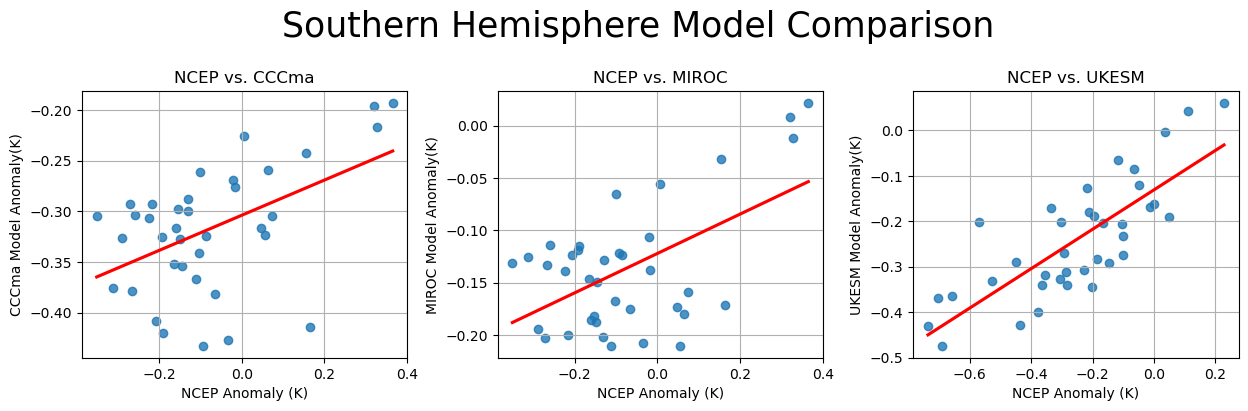

In [117]:
fig = plt.figure(figsize = (16,4))
nrows = 30
ncols = 30
ax1 = plt.subplot2grid((nrows,ncols), (4,0), colspan=8, rowspan=26)
ax2 = plt.subplot2grid((nrows,ncols), (4,10), colspan=8, rowspan=26)
ax3 = plt.subplot2grid((nrows,ncols), (4,20), colspan=8, rowspan=26)

ax1.grid()
sns.regplot(x=ncep_SH_mean, y=CCCma_SH_mean, ci=False, line_kws={'color':'red'}, ax=ax1);
ax1.set(xlabel="NCEP Anomaly (K)", ylabel="CCCma Model Anomaly(K)",
       title="NCEP vs. CCCma")

ax2.grid()
sns.regplot(x=ncep_SH_mean, y=MIROC_SH_mean, ci=False, line_kws={'color':'red'}, ax=ax2);
ax2.set(xlabel="NCEP Anomaly (K)", ylabel="MIROC Model Anomaly(K)",
       title="NCEP vs. MIROC")

ax3.grid()
sns.regplot(x=ncep_NH_mean, y=UKESM_NH_mean, ci=False, line_kws={'color':'red'}, ax=ax3);
ax3.set(xlabel="NCEP Anomaly (K)", ylabel="UKESM Model Anomaly(K)",
       title="NCEP vs. UKESM")

fig.suptitle("Southern Hemisphere Model Comparison        ", fontsize=25)

result1 = sc.stats.linregress(ncep_SH_mean, CCCma_SH_mean)
print("CCCma")
print(f"slope = {result1.slope}")
print(f"intercept = {result1.intercept}")
print(f"r = {result1.rvalue}")
print(f"p = {result1.pvalue}")
print(f"stdev = {result1.stderr}")

result2 = sc.stats.linregress(ncep_SH_mean, MIROC_SH_mean)
print("MIROC")
print(f"slope = {result2.slope}")
print(f"intercept = {result2.intercept}")
print(f"r = {result2.rvalue}")
print(f"p = {result2.pvalue}")
print(f"stdev = {result2.stderr}")

result3 = sc.stats.linregress(ncep_SH_mean, UKESM_SH_mean)
print("UKESM")
print(f"slope = {result3.slope}")
print(f"intercept = {result3.intercept}")
print(f"r = {result3.rvalue}")
print(f"p = {result3.pvalue}")
print(f"stdev = {result3.stderr}")

CCCma
slope = 0.2820251245545132
intercept = -0.5979379273385882
r = 0.5739169473272341
p = 0.00020412973462112388
stdev = 0.0680209611591646
MIROC
slope = -0.019393764431736533
intercept = -0.241734552545274
r = -0.04049461128509812
p = 0.8119103306115136
stdev = 0.08088620992637079
UKESM
slope = 0.2141065800100903
intercept = -0.33529591482660964
r = 0.3435856326929135
p = 0.03733550471730941
stdev = 0.09891968203827463


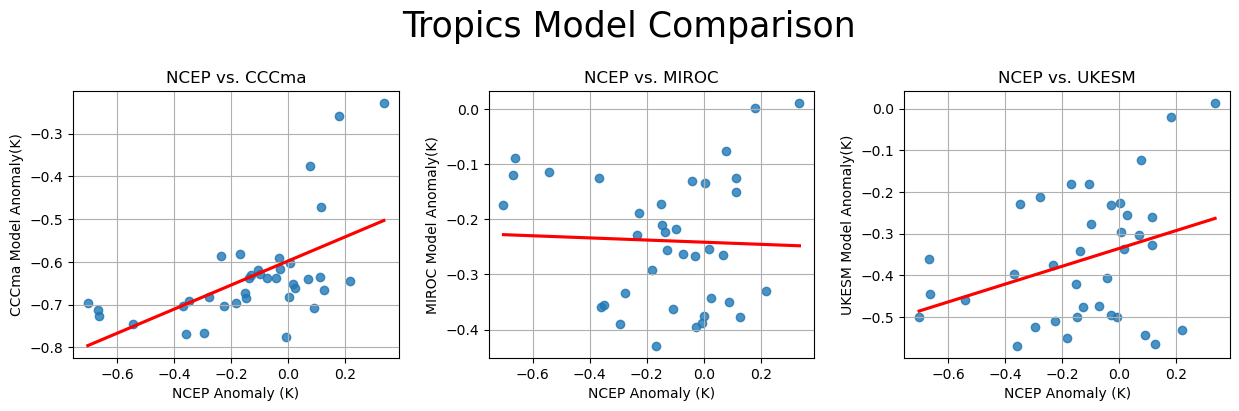

In [118]:
fig = plt.figure(figsize = (16,4))
nrows = 30
ncols = 30
ax1 = plt.subplot2grid((nrows,ncols), (4,0), colspan=8, rowspan=26)
ax2 = plt.subplot2grid((nrows,ncols), (4,10), colspan=8, rowspan=26)
ax3 = plt.subplot2grid((nrows,ncols), (4,20), colspan=8, rowspan=26)

ax1.grid()
sns.regplot(x=ncep_trop_mean, y=CCCma_trop_mean, ci=False, line_kws={'color':'red'}, ax=ax1);
ax1.set(xlabel="NCEP Anomaly (K)", ylabel="CCCma Model Anomaly(K)",
       title="NCEP vs. CCCma")

ax2.grid()
sns.regplot(x=ncep_trop_mean, y=MIROC_trop_mean, ci=False, line_kws={'color':'red'}, ax=ax2);
ax2.set(xlabel="NCEP Anomaly (K)", ylabel="MIROC Model Anomaly(K)",
       title="NCEP vs. MIROC")

ax3.grid()
sns.regplot(x=ncep_trop_mean, y=UKESM_trop_mean, ci=False, line_kws={'color':'red'}, ax=ax3);
ax3.set(xlabel="NCEP Anomaly (K)", ylabel="UKESM Model Anomaly(K)",
       title="NCEP vs. UKESM")
fig.suptitle("Tropics Model Comparison        ", fontsize=25)

result1 = sc.stats.linregress(ncep_trop_mean, CCCma_trop_mean)
print("CCCma")
print(f"slope = {result1.slope}")
print(f"intercept = {result1.intercept}")
print(f"r = {result1.rvalue}")
print(f"p = {result1.pvalue}")
print(f"stdev = {result1.stderr}")

result2 = sc.stats.linregress(ncep_trop_mean, MIROC_trop_mean)
print("MIROC")
print(f"slope = {result2.slope}")
print(f"intercept = {result2.intercept}")
print(f"r = {result2.rvalue}")
print(f"p = {result2.pvalue}")
print(f"stdev = {result2.stderr}")

result3 = sc.stats.linregress(ncep_trop_mean, UKESM_trop_mean)
print("UKESM")
print(f"slope = {result3.slope}")
print(f"intercept = {result3.intercept}")
print(f"r = {result3.rvalue}")
print(f"p = {result3.pvalue}")
print(f"stdev = {result3.stderr}")

CCCma
slope = 0.4725470326568549
intercept = -0.28928645126992764
r = 0.6503120511790461
p = 1.3203348933188548e-05
stdev = 0.0933066472496679
MIROC
slope = 0.1432709514358017
intercept = -0.10770640057735806
r = 0.4607833211674488
p = 0.004104093049781752
stdev = 0.04664465996683436
UKESM
slope = 0.1440368751654122
intercept = -0.05669480460841275
r = 0.4100673640741778
p = 0.01171266013790175
stdev = 0.05415089063374693


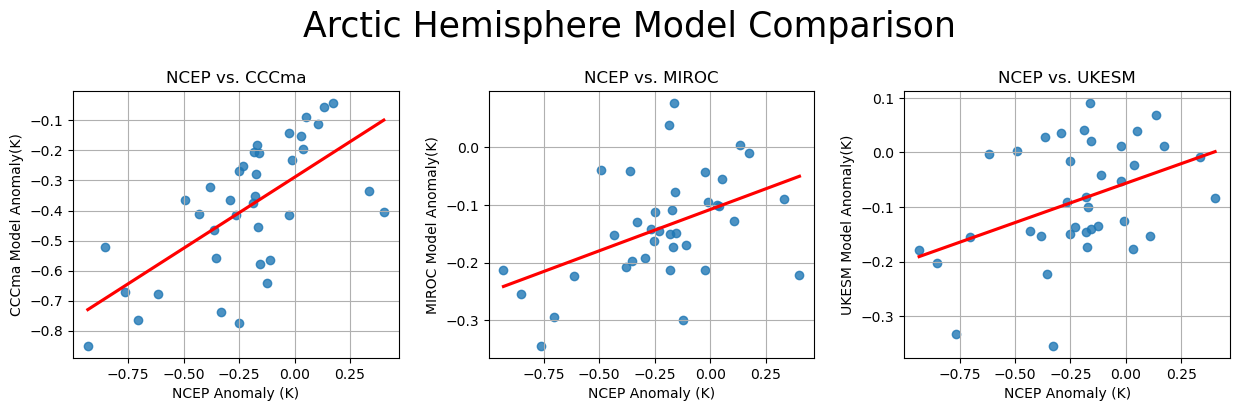

In [119]:
fig = plt.figure(figsize = (16,4))
nrows = 30
ncols = 30
ax1 = plt.subplot2grid((nrows,ncols), (4,0), colspan=8, rowspan=26)
ax2 = plt.subplot2grid((nrows,ncols), (4,10), colspan=8, rowspan=26)
ax3 = plt.subplot2grid((nrows,ncols), (4,20), colspan=8, rowspan=26)

ax1.grid()
sns.regplot(x=ncep_arc_mean, y=CCCma_arc_mean, ci=False, line_kws={'color':'red'}, ax=ax1);
ax1.set(xlabel="NCEP Anomaly (K)", ylabel="CCCma Model Anomaly(K)",
       title="NCEP vs. CCCma")

ax2.grid()
sns.regplot(x=ncep_arc_mean, y=MIROC_arc_mean, ci=False, line_kws={'color':'red'}, ax=ax2);
ax2.set(xlabel="NCEP Anomaly (K)", ylabel="MIROC Model Anomaly(K)",
       title="NCEP vs. MIROC")

ax3.grid()
sns.regplot(x=ncep_arc_mean, y=UKESM_arc_mean, ci=False, line_kws={'color':'red'}, ax=ax3);
ax3.set(xlabel="NCEP Anomaly (K)", ylabel="UKESM Model Anomaly(K)",
       title="NCEP vs. UKESM")

fig.suptitle("Arctic Hemisphere Model Comparison        ", fontsize=25)

result1 = sc.stats.linregress(ncep_arc_mean, CCCma_arc_mean)
print("CCCma")
print(f"slope = {result1.slope}")
print(f"intercept = {result1.intercept}")
print(f"r = {result1.rvalue}")
print(f"p = {result1.pvalue}")
print(f"stdev = {result1.stderr}")

result2 = sc.stats.linregress(ncep_arc_mean, MIROC_arc_mean)
print("MIROC")
print(f"slope = {result2.slope}")
print(f"intercept = {result2.intercept}")
print(f"r = {result2.rvalue}")
print(f"p = {result2.pvalue}")
print(f"stdev = {result2.stderr}")

result3 = sc.stats.linregress(ncep_arc_mean, UKESM_arc_mean)
print("UKESM")
print(f"slope = {result3.slope}")
print(f"intercept = {result3.intercept}")
print(f"r = {result3.rvalue}")
print(f"p = {result3.pvalue}")
print(f"stdev = {result3.stderr}")

Text(0.5, 0.98, 'Regional Model Comparison to Reanalysis Data         ')

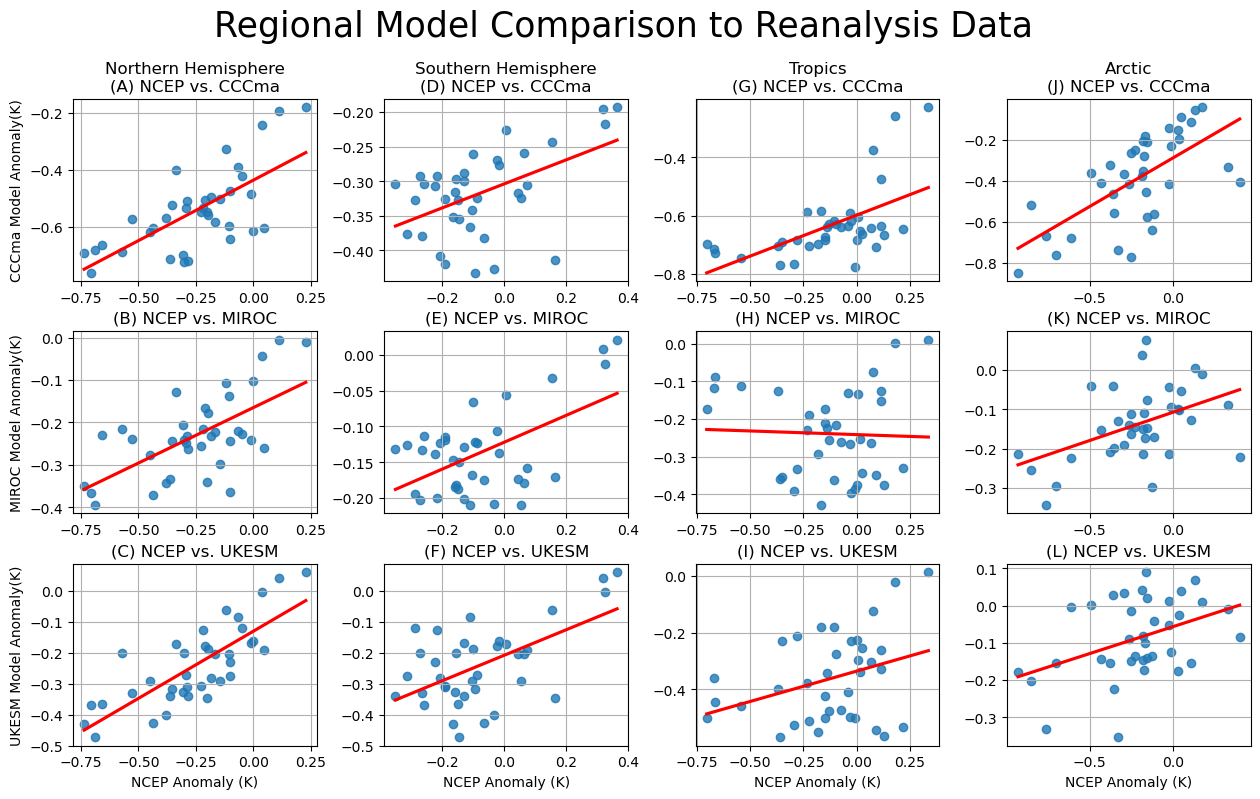

In [120]:
fig = plt.figure(figsize = (16,9))
nrows = 30
ncols = 40
ax1 = plt.subplot2grid((nrows,ncols), (0,0), colspan=8, rowspan=8)
ax2 = plt.subplot2grid((nrows,ncols), (10,0), colspan=8, rowspan=8)
ax3 = plt.subplot2grid((nrows,ncols), (20,0), colspan=8, rowspan=8)
ax4 = plt.subplot2grid((nrows,ncols), (0,10), colspan=8, rowspan=8)
ax5 = plt.subplot2grid((nrows,ncols), (10,10), colspan=8, rowspan=8)
ax6 = plt.subplot2grid((nrows,ncols), (20,10), colspan=8, rowspan=8)
ax7 = plt.subplot2grid((nrows,ncols), (0,20), colspan=8, rowspan=8)
ax8 = plt.subplot2grid((nrows,ncols), (10,20), colspan=8, rowspan=8)
ax9 = plt.subplot2grid((nrows,ncols), (20,20), colspan=8, rowspan=8)
ax10 = plt.subplot2grid((nrows,ncols), (0,30), colspan=8, rowspan=8)
ax11 = plt.subplot2grid((nrows,ncols), (10,30), colspan=8, rowspan=8)
ax12 = plt.subplot2grid((nrows,ncols), (20,30), colspan=8, rowspan=8)

ax1.grid()
sns.regplot(x=ncep_NH_mean, y=CCCma_NH_mean, ci=False, line_kws={'color':'red'}, ax=ax1);
ax1.set(ylabel="CCCma Model Anomaly(K)",
        title="Northern Hemisphere\n(A) NCEP vs. CCCma")

ax2.grid()
sns.regplot(x=ncep_NH_mean, y=MIROC_NH_mean, ci=False, line_kws={'color':'red'}, ax=ax2);
ax2.set(ylabel="MIROC Model Anomaly(K)",
        title="(B) NCEP vs. MIROC")

ax3.grid()
sns.regplot(x=ncep_NH_mean, y=UKESM_NH_mean, ci=False, line_kws={'color':'red'}, ax=ax3);
ax3.set(xlabel="NCEP Anomaly (K)", ylabel="UKESM Model Anomaly(K)",
        title="(C) NCEP vs. UKESM")

ax4.grid()
sns.regplot(x=ncep_SH_mean, y=CCCma_SH_mean, ci=False, line_kws={'color':'red'}, ax=ax4);
ax4.set(title="Southern Hemisphere\n(D) NCEP vs. CCCma")

ax5.grid()
sns.regplot(x=ncep_SH_mean, y=MIROC_SH_mean, ci=False, line_kws={'color':'red'}, ax=ax5);
ax5.set(title="(E) NCEP vs. MIROC")

ax6.grid()
sns.regplot(x=ncep_SH_mean, y=UKESM_NH_mean, ci=False, line_kws={'color':'red'}, ax=ax6);
ax6.set(xlabel="NCEP Anomaly (K)",
        title="(F) NCEP vs. UKESM")

ax7.grid()
sns.regplot(x=ncep_trop_mean, y=CCCma_trop_mean, ci=False, line_kws={'color':'red'}, ax=ax7);
ax7.set(title="Tropics\n(G) NCEP vs. CCCma")

ax8.grid()
sns.regplot(x=ncep_trop_mean, y=MIROC_trop_mean, ci=False, line_kws={'color':'red'}, ax=ax8);
ax8.set(title="(H) NCEP vs. MIROC")

ax9.grid()
sns.regplot(x=ncep_trop_mean, y=UKESM_trop_mean, ci=False, line_kws={'color':'red'}, ax=ax9);
ax9.set(xlabel="NCEP Anomaly (K)",
        title="(I) NCEP vs. UKESM")
ax10.grid()
sns.regplot(x=ncep_arc_mean, y=CCCma_arc_mean, ci=False, line_kws={'color':'red'}, ax=ax10);
ax10.set(title="Arctic\n(J) NCEP vs. CCCma")

ax11.grid()
sns.regplot(x=ncep_arc_mean, y=MIROC_arc_mean, ci=False, line_kws={'color':'red'}, ax=ax11);
ax11.set(title="(K) NCEP vs. MIROC")

ax12.grid()
sns.regplot(x=ncep_arc_mean, y=UKESM_arc_mean, ci=False, line_kws={'color':'red'}, ax=ax12);
ax12.set(xlabel="NCEP Anomaly (K)",
         title="(L) NCEP vs. UKESM")
fig.suptitle("Regional Model Comparison to Reanalysis Data         ", fontsize=25)

CCCma
slope = 0.3910822825820171
intercept = -0.3661942326306954
r = 0.8043263488856922
p = 2.0068042785431366e-09
stdev = 0.048834364801011235
MIROC
slope = 0.26970160460388143
intercept = -0.13937681040191388
r = 0.6837023692216756
p = 3.095580492308591e-06
stdev = 0.04865898597237498
UKESM
slope = 0.3296951453253801
intercept = -0.15472770463995567
r = 0.6530534428589568
p = 1.1799272043100617e-05
stdev = 0.06462559358344529


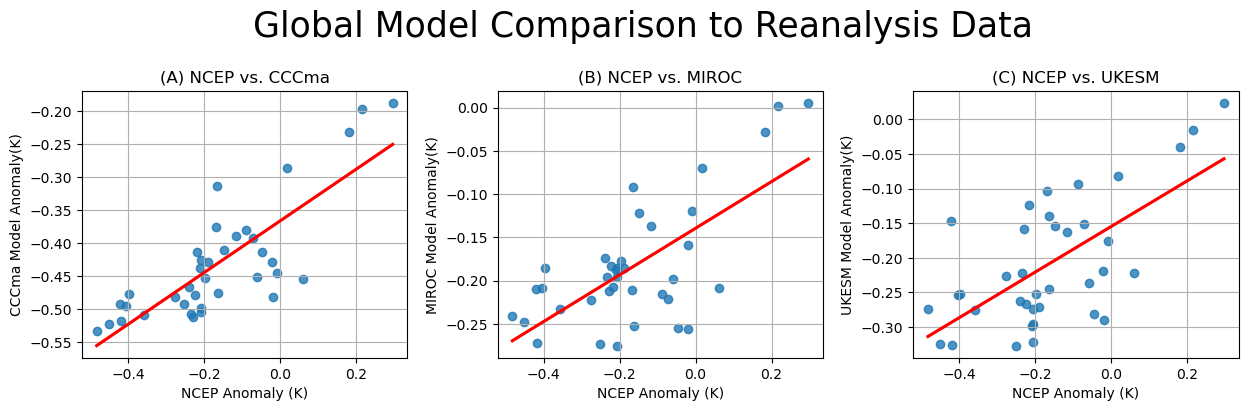

In [121]:
fig = plt.figure(figsize = (16,4))
nrows = 30
ncols = 30
ax1 = plt.subplot2grid((nrows,ncols), (4,0), colspan=8, rowspan=26)
ax2 = plt.subplot2grid((nrows,ncols), (4,10), colspan=8, rowspan=26)
ax3 = plt.subplot2grid((nrows,ncols), (4,20), colspan=8, rowspan=26)

ax1.grid()
sns.regplot(x=ncep_glb_mean_values, y=CCCma_glb_mean_values, ci=False, line_kws={'color':'red'}, ax=ax1);
ax1.set(xlabel="NCEP Anomaly (K)", ylabel="CCCma Model Anomaly(K)",
       title="(A) NCEP vs. CCCma")

ax2.grid()
sns.regplot(x=ncep_glb_mean_values, y=MIROC_glb_mean_values, ci=False, line_kws={'color':'red'}, ax=ax2);
ax2.set(xlabel="NCEP Anomaly (K)", ylabel="MIROC Model Anomaly(K)",
       title="(B) NCEP vs. MIROC")

ax3.grid()
sns.regplot(x=ncep_glb_mean_values, y=UKESM_glb_mean_values, ci=False, line_kws={'color':'red'}, ax=ax3);
ax3.set(xlabel="NCEP Anomaly (K)", ylabel="UKESM Model Anomaly(K)",
       title="(C) NCEP vs. UKESM")

fig.suptitle("Global Model Comparison to Reanalysis Data       ", fontsize=25)

result1 = sc.stats.linregress(ncep_glb_mean_values, CCCma_glb_mean_values)
print("CCCma")
print(f"slope = {result1.slope}")
print(f"intercept = {result1.intercept}")
print(f"r = {result1.rvalue}")
print(f"p = {result1.pvalue}")
print(f"stdev = {result1.stderr}")

result2 = sc.stats.linregress(ncep_glb_mean_values, MIROC_glb_mean_values)
print("MIROC")
print(f"slope = {result2.slope}")
print(f"intercept = {result2.intercept}")
print(f"r = {result2.rvalue}")
print(f"p = {result2.pvalue}")
print(f"stdev = {result2.stderr}")

result3 = sc.stats.linregress(ncep_glb_mean_values, UKESM_glb_mean_values)
print("UKESM")
print(f"slope = {result3.slope}")
print(f"intercept = {result3.intercept}")
print(f"r = {result3.rvalue}")
print(f"p = {result3.pvalue}")
print(f"stdev = {result3.stderr}")